# Synthetic drifter trajectories exponentially autocorrelated velocities

We generate synthetic exponentially autocorrelated velocity timeseries.
Displacement and acceleration timeseries are derived.

We verify pure exponentially decorrelated timeseries are not differentiable and lead to white noise acceleration.
A modification leading to differentiable solutions is used and consists in (multi-layer) embeded Ornstein–Uhlenbeck (OU) processes [Sawford 1991, Viggiano et al. 2020].
All processes are assumed Gaussian and could be extended to more general distributions [Viggiano et al. 2020].

References:

- B. Viggiano, J. Friedrich, R. Volk, M. Bourgoin, R. B. Cal, and L. Chevillard. Modelling lagrangian velocity and acceleration in turbulent flows as infinitely differentiable stochastic processes. Journal of Fluid Mechanics, 900, 2020.
- B. Sawford. Reynolds number effects in lagrangian stochastic models of turbulent dispersion. Physics of Fluids A: Fluid Dynamics, 3(6):1577–1586, 1991.


---

# Embedded OU processes: Viggiano et al. 2020  + white noise

We generate timeseries corresponding to their equations (2.14-2.18).
- noised trajectories
- spectra 


In [1]:
import os
import xarray as xr
import numpy as np


import matplotlib.pyplot as plt
from cycler import cycler

import viggiano_2020 as vig
import plot as fplt
from sstats import signals as sg
from sstats import sigp as sigp
from sstats import tseries as ts
from sstats import get_cmap_colors

In [2]:
from GDP_lib import root_dir

In [10]:
from dask.distributed import Client

if False :
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster(cores=56, processes=28, walltime='04:00:00')
    #cluster = PBSCluster(cores=7, processes=7, walltime='04:00:00')
    cluster = PBSCluster(cores=3, processes=3, walltime='04:00:00')
    w = cluster.scale(jobs=8)
    #from dask_jobqueue import PBSCluster
    #cluster = PBSCluster()
    #w = cluster.scale(jobs=8) # 5 for gps, 8 for argos
else:
    from dask.distributed import LocalCluster
    cluster = LocalCluster()
    
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 56,Total memory: 100.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38619,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 56
Started: Just now,Total memory: 100.00 GiB
Comm: tcp://127.0.0.1:60095,Total threads: 7
Dashboard: http://127.0.0.1:54982/status,Memory: 12.50 GiB
Nanny: tcp://127.0.0.1:49479,


In [8]:
#root_dir ='/Users/mdemol/code/PhD/GDP/synthetics_trajectories'
path = os.path.join(root_dir, "noised_synthetic_traj_ou.zarr")
ds = xr.open_zarr(path, decode_timedelta=False).persist()
colors = get_cmap_colors(ds.T.size, cmap="plasma")
plt.rc('axes', prop_cycle=cycler(color=colors))
ds


<xarray.Dataset>
Dimensions:     (T: 4, draw: 100, freq_time: 2400, time: 24000, lags: 24000)
Coordinates:
  * T           (T) int64 5 10 20 40
  * draw        (draw) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
  * freq_time   (freq_time) float64 -12.0 -11.99 -11.98 ... 11.97 11.98 11.99
  * lags        (lags) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
  * time        (time) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
Data variables: (12/154)
    Ea          (T, draw, freq_time) float64 dask.array<chunksize=(4, 100, 2400), meta=np.ndarray>
    Ea_nu025    (T, draw, freq_time) float64 dask.array<chunksize=(4, 100, 2400), meta=np.ndarray>
    Ea_nu05     (T, draw, freq_time) float64 dask.array<chunksize=(4, 100, 2400), meta=np.ndarray>
    Ea_nu075    (T, draw, freq_time) float64 dask.array<chunksize=(4, 100, 2400), meta=np.ndarray>
    Ea_nu1      (T, draw, freq_time) float64 dask.array<chunksize=(4, 100, 2400), meta=np.ndarray>
    Ea_nx025    (T, draw, freq_time) float64 dask.array<chunksize=(4, 100, 2400), meta=np.ndarray>
    ...          ...
    xx_nu075    (T, draw, lags) float64 dask.array<chunksize=(4, 100, 5000), meta=np.ndarray>
    xx_nu1      (T, draw, lags) float64 dask.array<chunksize=(4, 100, 5000), meta=np.ndarray>
    xx_nx025    (T, draw, lags) float64 dask.array<chunksize=(4, 100, 5000), meta=np.ndarray>
    xx_nx05     (T, draw, lags) float64 dask.array<chunksize=(4, 100, 5000), meta=np.ndarray>
    xx_nx075    (T, draw, lags) float64 dask.array<chunksize=(4, 100, 5000), meta=np.ndarray>
    xx_nx1      (T, draw, lags) float64 dask.array<chunksize=(4, 100, 5000), meta=np.ndarray>
Attributes:
    description:                synthetic trajectories simulated via the embe...
    n_layers:                   5
    noise_suffixe_description:  _n + variable $v$ to which the white noised i...
    noise_suffixes_legend:      {'_nu025': '$\\sigma_{\\epsilon} =0.25\\sigma...
    sigma_u:                    1
    tau_eta_days:               0.041666666666666664

## Plotting functions

In [4]:
colors = get_cmap_colors(ds.T.size, cmap="plasma")
plt.rc('axes', prop_cycle=cycler(color=colors))

letter = ['(a)','(b)','(c)']
def plot_timeseries(ds, tmax=100, suffixes_ls ={'':'solid'}, suffixes_leg={'':''},  title = ''):

    fig, axes = plt.subplots(1,3, figsize=(12,4), sharex=True)

    ax = axes[0]
    for suf in suffixes_ls :         
        ds["x"+suf].where(ds.time < tmax).plot.line(x="time", ax=ax, ls=suffixes_ls[suf]);
    ax.grid()
    ax.set_title("")
    ax.set_ylabel("Position x [m]")
    ax.set_xlabel("Time [days]")


    ax = axes[1]
    for suf in suffixes_ls :         
        ds["u"+suf].where(ds.time < tmax).plot.line(x="time", ax=ax, ls=suffixes_ls[suf],add_legend=False);
    ax.grid()
    ax.set_title("")
    ax.set_ylabel("Velocity u [m/s]")
    ax.set_xlabel("Time [days]")

    ax = axes[2]
    for suf in suffixes_ls :         
        ds["a"+suf].where(ds.time < tmax).plot.line(x="time", ax=ax, ls=suffixes_ls[suf], add_legend=False);
    ax.grid()
    ax.set_title("")
    ax.set_ylabel(r"Acceleration a [$m^2$/s]")
    ax.set_xlabel("Time [days]")

    
    #if len(suffixes_ls)>1 : 
        #leg = ''
        #for suf in suffixes_leg: 
            #leg += suffixes_ls[suf] +' : ' + suffixes_leg[suf]+'\n'
        #fig.text(0.5, -0.01, leg, ha="center")#, fontsize=18)#, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
    
    # letters
    for i in range(3):
        axes[i].set_title(letter[i])
    
    fig.tight_layout(rect=[0,0.05,1,0.95])#left, bottom, right, top (default is 0,0,1,1)
    fig.suptitle(title)
    return fig, axes

def plot_autocorrelations(ds, tau_max=100, suffixes_ls ={'':'solid'}, suffixes_leg={'':''}, title=''):
    #Correlation are normalised by the variance
    fig, axes = plt.subplots(1,3, figsize=(12,4), sharex=True)

    ax = axes[0]
    for suf in suffixes_ls : 
        (ds["xx"+suf]/ds["xx"+suf].sel(lags=0)).where(ds.lags < tau_max).plot.line(x="lags", ax=ax, ls = suffixes_ls[suf]);  
    ax.grid()
    ax.set_title("")
    ax.set_ylabel(r"$C_x$")
    ax.set_xlabel(r"$\tau$ [days]")


    ax = axes[1]
    for suf in suffixes_ls : 
        (ds["uu"+suf]/ds["uu"+suf].sel(lags=0)).where(ds.lags < tau_max).plot.line(x="lags", ax=ax, ls = suffixes_ls[suf],add_legend=False);  
    ax.grid()
    ax.set_title("")
    ax.set_ylabel(r"$C_u$")
    ax.set_xlabel(r"$\tau$ [days]")

    ax = axes[2]
    for suf in suffixes_ls : 
        (ds["aa"+suf]/ds["aa"+suf].sel(lags=0)).where(ds.lags < tau_max).plot.line(x="lags", ax=ax, ls = suffixes_ls[suf],add_legend=False);  
    ax.grid()
    ax.set_title("")
    ax.set_ylabel(r"$C_a$")
    ax.set_xlabel(r"$\tau$ [days]")
    
    #if len(suffixes_ls)>1 : 
        #leg = ''
       # for suf in suffixes_leg: 
           # leg += suffixes_ls [suf] +' : ' + suffixes_leg[suf]+'\n'
        #fig.text(0.5, -0.01, leg, ha="center")#, fontsize=18)#, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})

    # letters
    for i in range(3):
        axes[i].set_title(letter[i])

    fig.tight_layout(rect=[0,0.05,1,0.95])#left, bottom, right, top (default is 0,0,1,1)
    fig.suptitle(title)
    return fig, axes

def plot_spectraloglog(ds, suffixes_ls ={'':'solid'}, suffixes_leg={'':''}, title='') : 
    fig, axs = plt.subplots(1,2, figsize=(9,5), sharex=True)#, sharey=True)

    for _T, c in zip(ds.T, colors):
        ax=axs[0]
        i=True
        for suf in suffixes_ls :  
            _E = ds['Eu'+suf].mean("draw")
            _Enorm = ds['Eu'].mean("draw").sel(freq_time=0)
            if i :
                #(_E/_E.sel(freq_time=0)).sel(T=_T).plot(x="freq_time", ax=ax, color=c, ls =suffixes_ls[suf], label=f"T={float(_T):.0f}d")
                #(_E/_Enorm).sel(T=_T).plot(x="freq_time", ax=ax, color=c, ls =suffixes_ls[suf], label=f"T={float(_T):.0f}d")
                _E.sel(T=_T).plot(x="freq_time", ax=ax, color=c, ls =suffixes_ls[suf], label=f"T={float(_T):.0f}d")
                i=False
            else : 
                #(_E/_E.sel(freq_time=0)).sel(T=_T).plot(x="freq_time", ax=ax, color=c, ls = suffixes_ls[suf])
                _E.sel(T=_T).plot(x="freq_time", ax=ax, color=c, ls = suffixes_ls[suf])
                #(_E/_Enorm).sel(T=_T).plot(x="freq_time", ax=ax, color=c, ls = suffixes_ls[suf])


        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("f[cpd]")
        ax.set_ylabel("Velocity normalized power density spectra Eu")
        ax.grid()
        ax.set_title('(a)')
                
    
        ax=axs[1]
        for suf in suffixes_ls :  
            _E = ds['Ea'+suf].mean("draw")
            _Enorm = ds['Ea'].mean("draw").sel(freq_time=0)
            #(_E/_E.sel(freq_time=0)).sel(T=_T).plot(x="freq_time", ax=ax, color=c, ls = suffixes_ls[suf])
            #(_E/_Enorm).sel(T=_T).plot(x="freq_time", ax=ax, color=c, ls = suffixes_ls[suf])
            _E.sel(T=_T).plot(x="freq_time", ax=ax, color=c, ls = suffixes_ls[suf])
            
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("f[cpd]")
        ax.set_ylabel("Acceleration normalized power density spectra Ea")
        ax.set_title('(b)')
        #Eu.mean("draw").sel(tau_eta=1).plot(x="freq_time", ax=ax, hue="T")
        
    #if len(suffixes_ls)>1 : 
     #   leg = ''
      #  for suf in suffixes_leg: 
       #     leg += suffixes_ls [suf] +' : ' + suffixes_leg[suf]+'\n'
      #  fig.text(0.5, -0.01, leg, ha="center")#, fontsize=18)#, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})

    # Vertical limitation
    for ax in axs :
        for i in range(ds.T.size) : 
            if i==0 : ax.axvline(x = 1/ds.T[i], color=colors[i], ls=':', label='1/T')
            else : ax.axvline(x = 1/ds.T[i], color=colors[i], ls=':')
        ax.axvline(1/ds.attrs['tau_eta_days'], color = 'k',ls ='--', label=r'$1/\tau_{\eta}$')
   
    axs[0].legend()
    axs[0].grid()
    axs[1].grid()
    fig.tight_layout(rect=[0,0,1,0.95])#left, bottom, right, top (default is 0,0,1,1)
    fig.suptitle(title)
    
    return fig, ax

________
# Mean squares
## Verify sum

For $\alpha$ 'deterministic' variable and $\epsilon$ a white noise, $\alpha$ and $\epsilon$ are independant and we should have : 

$$\langle (\alpha +\epsilon)^2 \rangle = \langle \alpha^2 \rangle + \langle \epsilon^2 \rangle $$

Let's verify this relation for $\alpha$ the position $x$, the velocity $u$ or the acceleration $a$. 
The white noises added either to velocity or to position are also integrated/differentiated in parallele of the differentiation of the $\alpha + \epsilon$ integration/differentiation so that we have an idea of the noised part of $\alpha + \epsilon$.

In [5]:
def create_ds_rms(ds, list_var_name):
    ds_rms = xr.Dataset()
    for i in list_var_name : 
        ds_rms['rms_'+i] = np.sqrt((ds[i]**2).mean(dim=['time']))
        ds_rms['rms_'+i].attrs = ds[i].attrs
    return ds_rms

In [6]:
ds_rms = create_ds_rms(ds, [i for i in ds.keys() if i.startswith('x_') or i.startswith('u_') or i.startswith('a_') or 
                            i.startswith('nx_') or i.startswith('nu_') or i.startswith('na_')]+['x', 'u', 'a'])

In [7]:
ds_rms

<xarray.Dataset>
Dimensions:       (T: 4, draw: 100)
Coordinates:
  * T             (T) int64 5 10 20 40
  * draw          (draw) int64 0 1 2 3 4 5 6 7 8 ... 91 92 93 94 95 96 97 98 99
Data variables: (12/51)
    rms_a_nu025   (T, draw) float64 dask.array<chunksize=(4, 100), meta=np.ndarray>
    rms_a_nu05    (T, draw) float64 dask.array<chunksize=(4, 100), meta=np.ndarray>
    rms_a_nu075   (T, draw) float64 dask.array<chunksize=(4, 100), meta=np.ndarray>
    rms_a_nu1     (T, draw) float64 dask.array<chunksize=(4, 100), meta=np.ndarray>
    rms_a_nx025   (T, draw) float64 dask.array<chunksize=(4, 100), meta=np.ndarray>
    rms_a_nx05    (T, draw) float64 dask.array<chunksize=(4, 100), meta=np.ndarray>
    ...            ...
    rms_x_nx05    (T, draw) float64 dask.array<chunksize=(4, 100), meta=np.ndarray>
    rms_x_nx075   (T, draw) float64 dask.array<chunksize=(4, 100), meta=np.ndarray>
    rms_x_nx1     (T, draw) float64 dask.array<chunksize=(4, 100), meta=np.ndarray>
    rms_x         (T, draw) float64 dask.array<chunksize=(4, 100), meta=np.ndarray>
    rms_u         (T, draw) float64 dask.array<chunksize=(4, 100), meta=np.ndarray>
    rms_a         (T, draw) float64 dask.array<chunksize=(4, 100), meta=np.ndarray>

Text(0.5, 1.0, '')

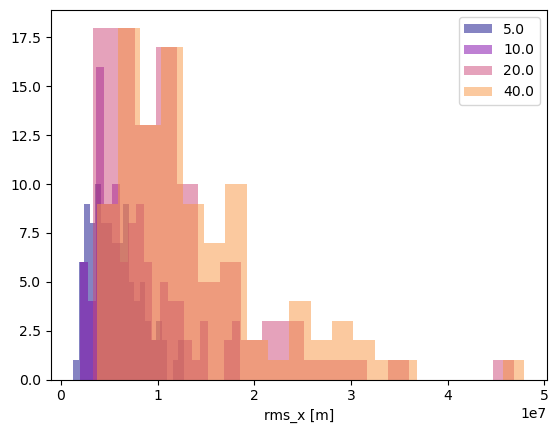

In [10]:
for _T in ds_rms['T']:
    ds_rms.rms_x.sel(T=_T).plot.hist(bins=20, alpha=0.5, label=float(_T))
plt.legend()
plt.title('')

Text(0.5, 1.0, '')

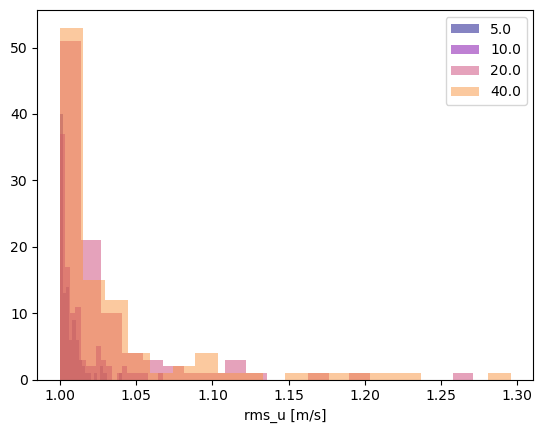

In [11]:
for _T in ds_rms['T']:
    ds_rms.rms_u.sel(T=_T).plot.hist(bins=20, alpha=0.5, label=float(_T))
plt.legend()
plt.title('')

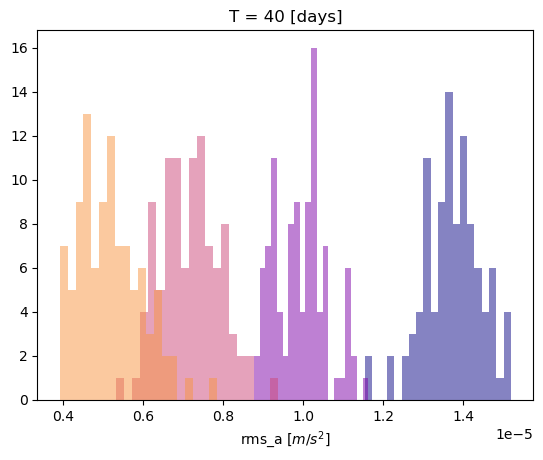

In [9]:
for _T in ds_rms['T']:
    ds_rms.rms_a.sel(T=_T).plot.hist(bins=20, alpha=0.5, label=float(_T))

In [21]:
def plot_ms(ds, suffixes):
    fig, axes = plt.subplots(1,3, figsize=(15,4),  sharex=True)
    axes = axes.flatten()
    a = np.arange(0, len(suffixes), 1)*2.5
    b = a + 1
    # Position ########
    ax=axes[0]
    ax.bar(a, [ds.rms_x**2]*len(suffixes),
          width = 1, zorder=3, label = r'$\langle \alpha^2 \rangle$')
    ax.bar(b,[ds['rms_x'+i]**2 for i in suffixes],
           width = 1, zorder=3, label = r'$\langle (\alpha + \epsilon_{\alpha})^2  \rangle$')
    ax.bar(a, [ds['rms_nx'+i]**2 for i in suffixes], bottom = [ds['rms_x']**2 for i in suffixes],
           width = 1, zorder=3, label = r'$\langle \epsilon_{\alpha}^2  \rangle$')
    ax.set_ylabel(r'$\langle ...^2\rangle$')
    ax.set_title('x[m]')
    
    # Velocity #########
    ax=axes[1]
    ax.bar(a, [ds.rms_u**2]*len(suffixes),
          width = 1, zorder=3)
    ax.bar(b,[ds['rms_u'+i]**2 for i in suffixes],
           width = 1, zorder=3)
    ax.bar(a, [ds['rms_nu'+i]**2 for i in suffixes], bottom = [ds['rms_u']**2 for i in suffixes],
           width = 1, zorder=3)
    #
    #for i in range(len(suffixes)):
    #    ax.axhline(ds['rms_x'+suffixes[i]]**2*2/(3600**2), a[i]-0.5, a[i]+0.5, c='grey', ls='--', label=r'$2/3600^2\langle (x+\epsilon_{x})^2 \rangle$')
    #ax.axhline(ds.rms_x**2 *2/(3600**2), c='grey', ls='--', label=r'$2/3600^2\langle x^2 \rangle$')
    
    ax.set_ylabel(r'$\langle ...^2\rangle$')
    ax.set_title('u[m/s]')
    
    # Acceleration #######
    ax=axes[2]
    ax.bar(a, [ds.rms_a**2]*len(suffixes),
          width = 1, zorder=3)
    ax.bar(b,[ds['rms_a'+i]**2 for i in suffixes],
           width = 1, zorder=3)
    ax.bar(a, [ds['rms_na'+i]**2 for i in suffixes], bottom = [ds['rms_a']**2 for i in suffixes],
           width = 1, zorder=3)
    ax.set_ylabel(r'$\langle ...^2\rangle$')
    ax.set_title(r'a[$m^2$/s]')
    
    #for i in range(len(suffixes)):
     #   ax.axhline(ds['rms_u'+suffixes[i]]**2*2/(3600**2), a[i]-0.5, a[i]+0.5, c='grey', ls='--', label=r'$2/3600^2\langle (u+\epsilon_{u})^2 \rangle$')
    #ax.axhline(ds.rms_u**2 *2/(3600**2), c='grey', ls='--', label=r'$2/3600^2\langle u^2 \rangle$')
    
    for ax in axes:
        def find(str_):
            if 'u' in str_ : return 'u'
            if 'x' in str_ : return 'dx'
        ax.set_xticks(a+0.5, [l.replace('_nu', '').replace('_nx', '').replace('0', '0.')+r'x $\sigma^2_{'+find(l)+'}$' for l in suffixes])
        ax.grid(axis='y', zorder=0)
        ax.set_xlabel('Added white noise')
    fig.legend(bbox_to_anchor=(1,0), loc="lower right", bbox_transform=fig.transFigure, ncol=3,title=r"where $\alpha$ is in x, u or a, $\epsilon_{\alpha}$ the noise",)
    fig.tight_layout(rect=[0,0.15,1,1])#left, bottom, right, top (default is 0,0,1,1)

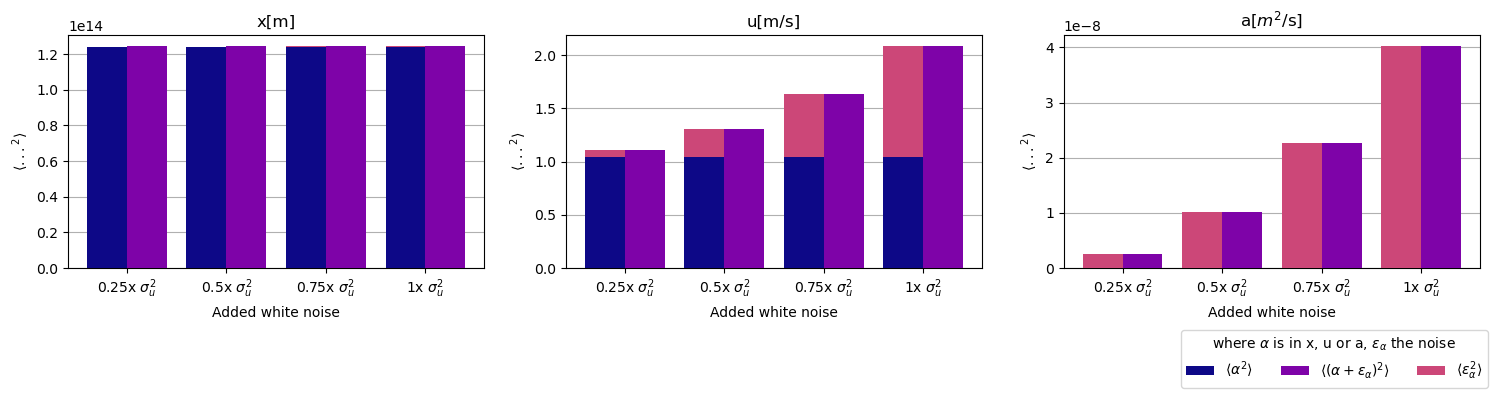

In [22]:
plot_ms(ds_rms.mean('draw').sel(T=20), suffixes=suffixes_u)

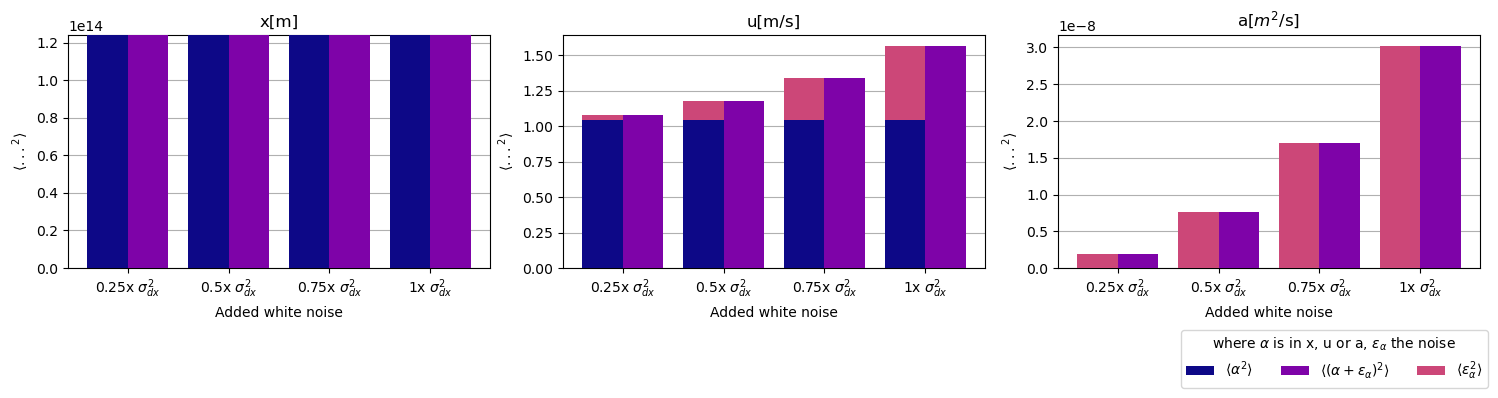

In [23]:
plot_ms(ds_rms.mean('draw').sel(T=20), suffixes=suffixes_x)

In [81]:
def plot_ms_ratio(ds, suffixes):
    fig, axes = plt.subplots(1,3, figsize=(15,4),  sharex=True, sharey=True)
    axes = axes.flatten()
    a = np.arange(0, len(suffixes), 1)*2.5
    b = a + 1
    # Position ########
    ax=axes[0]
    d = [(ds.rms_x**2+ds['rms_nx'+i]**2)/ds['rms_x'+i]**2 for i in suffixes]
    ax.bar(a, d,
          width = 2, zorder=3)#, label = r'$ ( \langle \alpha^2 \rangle + \langle \epsilon_{\alpha}^2 \rangle )/(\langle (\alpha +\epsilon_{\alpha})^2 \rangle $')
    for i in range(len(d)):
        ax.text(a[i]-1, d[i] +1e-2, str(np.format_float_scientific(d[i], precision = 3)))
    ax.axhline(1, color='r')    
    ax.set_ylabel(r'$ ( \langle \alpha^2 \rangle + \langle \epsilon_{\alpha}^2 \rangle )/\langle (\alpha +\epsilon_{\alpha})^2 \rangle $')
    ax.set_title('x[m]')
    ax.set_ylim(0.9,1.1)
    
    # Velocity #########
    ax=axes[1]
    d = [(ds.rms_u**2+ds['rms_nu'+i]**2)/ds['rms_u'+i]**2 for i in suffixes]
    ax.bar(a, d,
          width = 2, zorder=3)#, label = r'$ ( \langle \alpha^2 \rangle + \langle \epsilon_{\alpha}^2 \rangle )/(\langle (\alpha +\epsilon_{\alpha})^2 \rangle $')
    for i in range(len(d)):
        ax.text(a[i]-1, d[i] +1e-2, str(np.format_float_scientific(d[i], precision = 3)))
    ax.axhline(1, color='r') 
    ax.set_ylabel(r'$ ( \langle \alpha^2 \rangle + \langle \epsilon_{\alpha}^2 \rangle )/\langle (\alpha +\epsilon_{\alpha})^2 \rangle $')
    ax.set_title('u[m/s]')
    
    # Acceleration #######
    ax=axes[2]
    d = [(ds.rms_u**2+ds['rms_nu'+i]**2)/ds['rms_u'+i]**2 for i in suffixes]
    ax.bar(a, d,
          width = 2, zorder=3)#, label = r'$ ( \langle \alpha^2 \rangle + \langle \epsilon_{\alpha}^2 \rangle )/(\langle (\alpha +\epsilon_{\alpha})^2 \rangle $')
    for i in range(len(d)):
        ax.text(a[i]-1, d[i] +1e-2, str(np.format_float_scientific(d[i], precision = 3)))
    ax.axhline(1, color='r') 
    ax.set_ylabel(r'$ ( \langle \alpha^2 \rangle + \langle \epsilon_{\alpha}^2 \rangle )/\langle (\alpha +\epsilon_{\alpha})^2 \rangle $')
    ax.set_title(r'a[$m^2$/s]')

    for ax in axes:
        def find(str_):
            if 'u' in str_ : return 'u'
            if 'x' in str_ : return 'dx'
        ax.set_xticks(a+0.5, [l.replace('_nu', '').replace('_nx', '').replace('0', '0.')+r'x $\sigma^2_{'+find(l)+'}$' for l in suffixes])
        ax.grid(axis='y', zorder=0)
        ax.set_xlabel('Added white noise')
    #fig.legend(bbox_to_anchor=(1,0), loc="lower right", bbox_transform=fig.transFigure, ncol=3,title=r"where $\alpha$ is in x, u or a, $\epsilon_{\alpha}$ the noise",)
    fig.tight_layout(rect=[0,0.15,1,1])#left, bottom, right, top (default is 0,0,1,1)

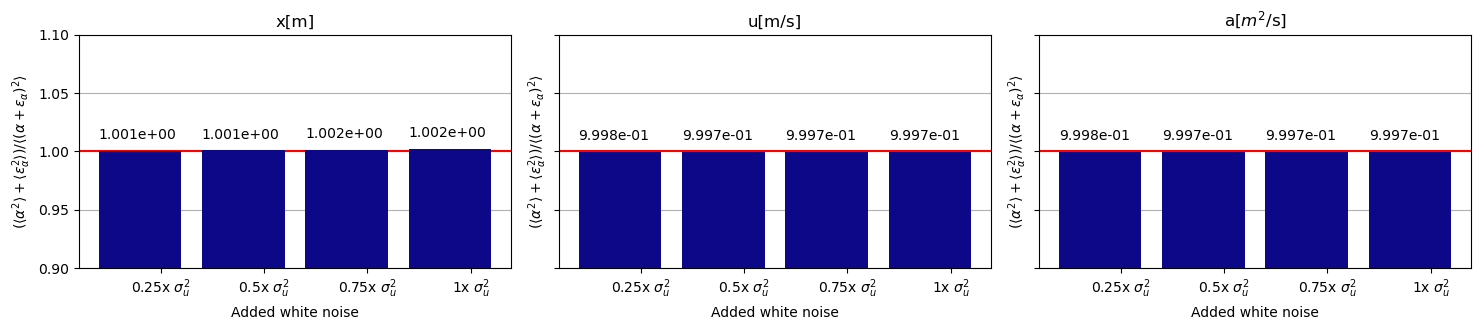

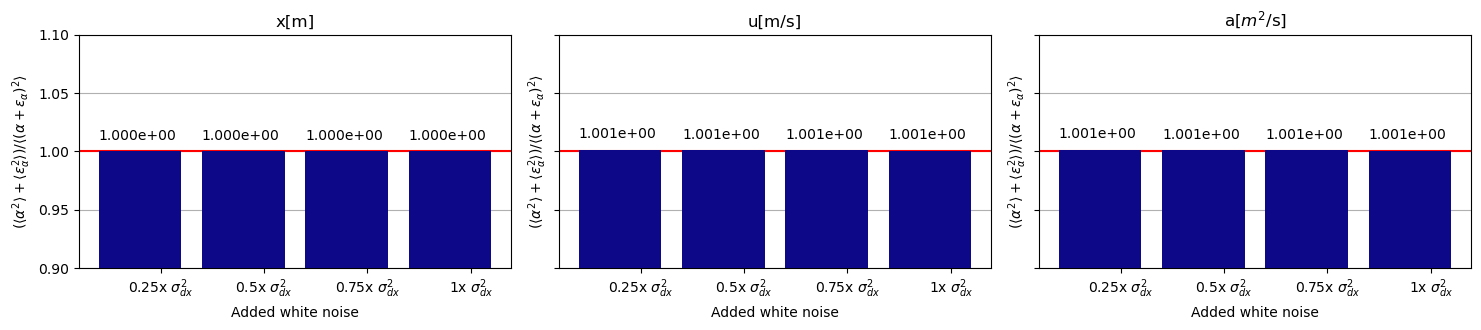

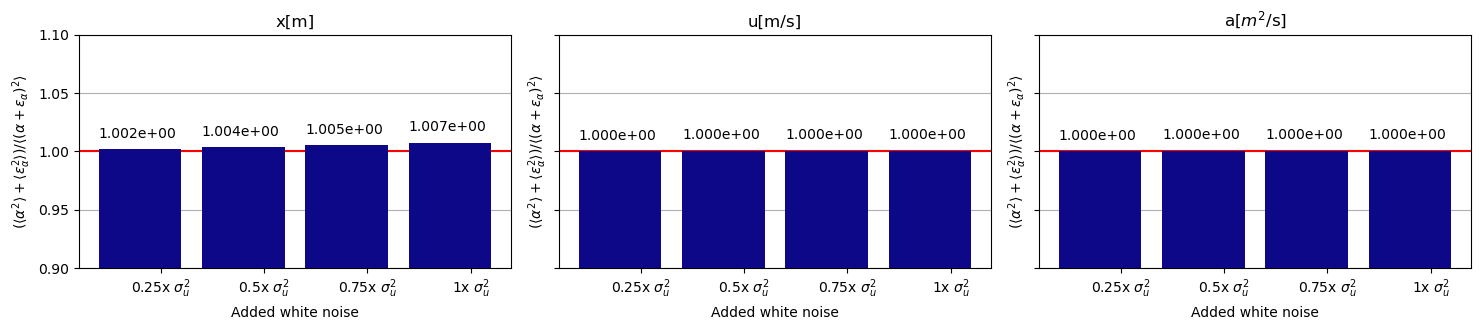

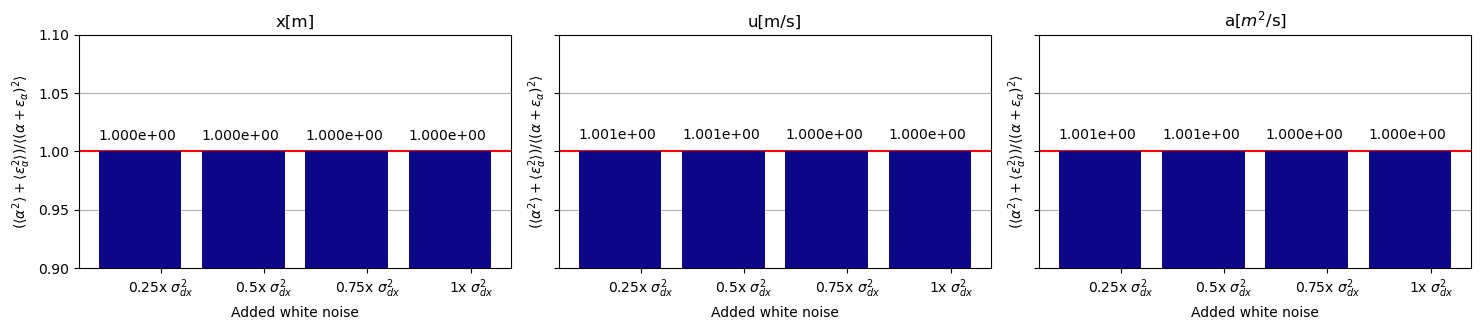

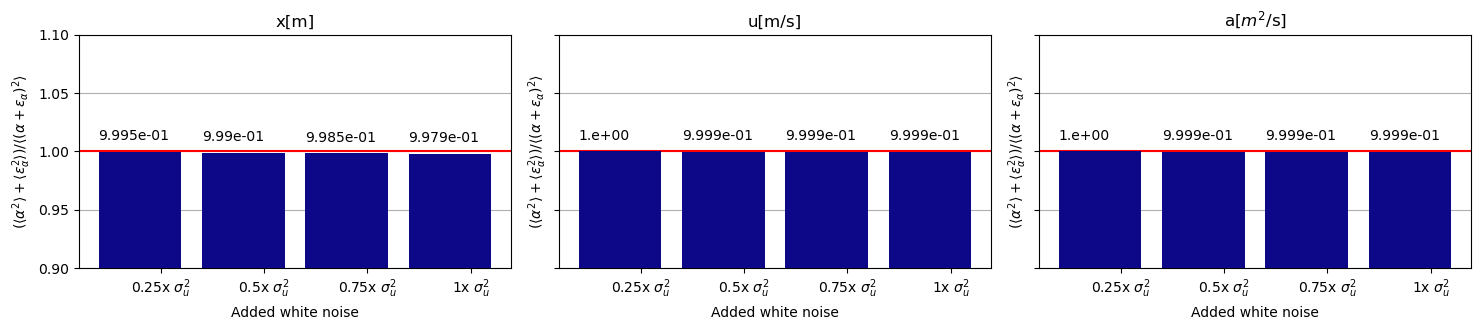

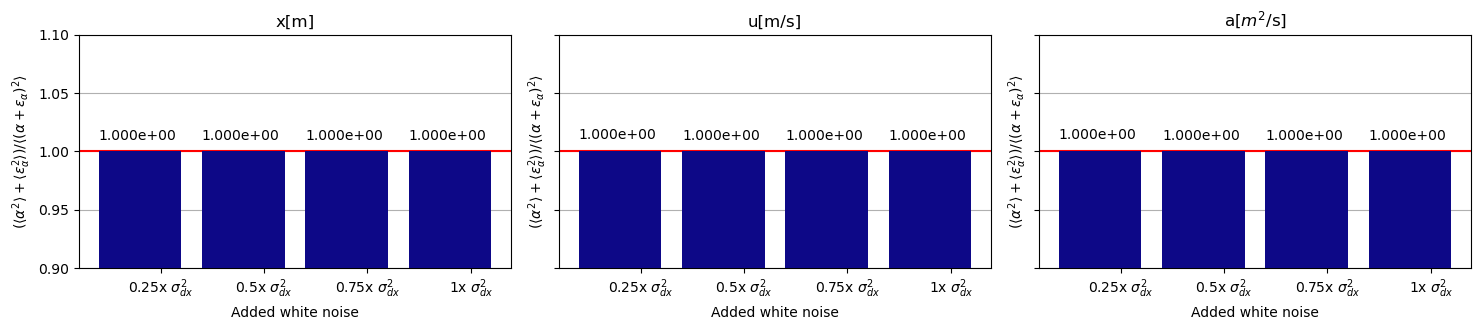

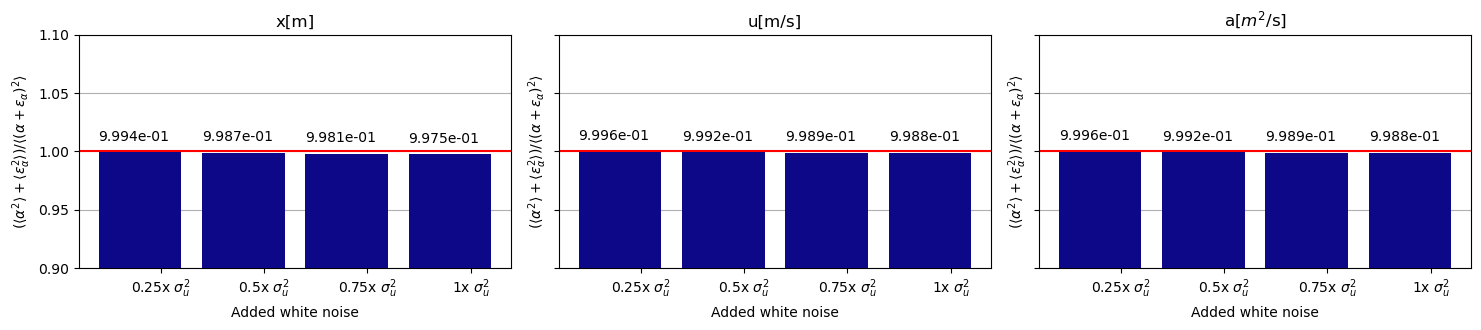

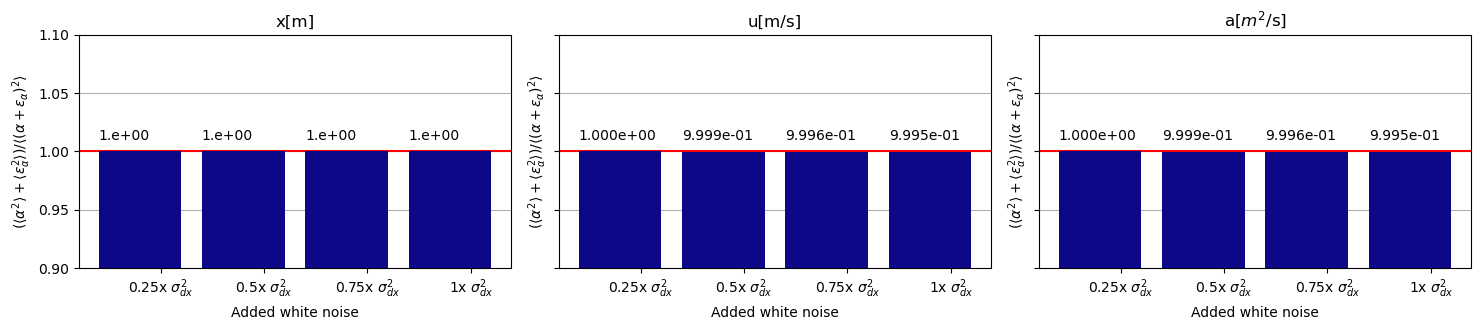

In [82]:
plot_ms_ratio(ds_rms.mean('draw').sel(T=5), suffixes=suffixes_u)
plot_ms_ratio(ds_rms.mean('draw').sel(T=5), suffixes=suffixes_x)
plot_ms_ratio(ds_rms.mean('draw').sel(T=10), suffixes=suffixes_u)
plot_ms_ratio(ds_rms.mean('draw').sel(T=10), suffixes=suffixes_x)
plot_ms_ratio(ds_rms.mean('draw').sel(T=20), suffixes=suffixes_u)
plot_ms_ratio(ds_rms.mean('draw').sel(T=20), suffixes=suffixes_x)
plot_ms_ratio(ds_rms.mean('draw').sel(T=40), suffixes=suffixes_u)
plot_ms_ratio(ds_rms.mean('draw').sel(T=40), suffixes=suffixes_x)

## Derivation effect on mean square
We have :

$\langle u^2 \rangle = \frac{2(1-C_x(dt))}{dt^2}\langle x^2 \rangle $ and $\langle a^2 \rangle = \frac{2(1-C_u(dt))}{dt^2}\langle u^2 \rangle $

Let's study :

$\gamma_u = \frac{2(1-C_x(dt))}{dt^2}\frac{\langle x^2 \rangle}{\langle u^2 \rangle}$ and $\gamma_a = \frac{2(1-C_u(dt))}{dt^2}\frac{\langle u^2 \rangle}{\langle a^2 \rangle}$

Do they tend to 1 ?

In [83]:
def cpte_gamma_u(ds, ds_rms, suf, dt=3600):
    u2 = ds_rms['rms_u'+suf]**2
    x2 = ds_rms['rms_x'+suf]**2
    cx = ds['xx'+suf].sel(lags=1/24) #non normalized 
    return 2*(x2 - cx)/(dt**2)/u2

def cpte_gamma_a(ds, ds_rms, suf, dt=3600):
    a2 = ds_rms['rms_a'+suf]**2
    u2 = ds_rms['rms_u'+suf]**2
    cu = ds['uu'+suf].sel(lags=1/24) #non normalized 
    return 2*(u2 - cu)/(dt**2)/a2

In [7]:
ds_gamma_u = cpte_gamma_u(ds, ds_rms, '')
ds_gamma_a = cpte_gamma_a(ds, ds_rms, '')

NameError: name 'cpte_gamma_u' is not defined

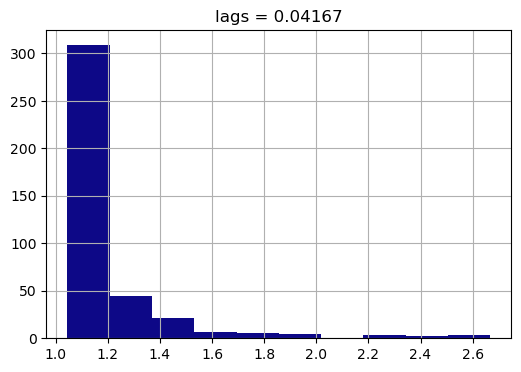

In [87]:
ds_gamma_a.plot.hist(figsize = (6,4))
plt.grid()

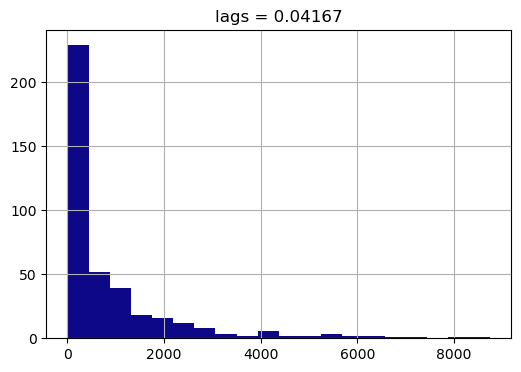

In [86]:
ds_gamma_u.plot.hist(figsize = (6,4), bins=20)
plt.grid()

##### CCL :  Work well for $\langle a^2\rangle$ but not for $\langle u^2\rangle$ -> the autocorrelation ahs its importance ! 
$x$ is here computed from the integration of $u$ (and not $u$ derivated from $x$ here), so this expression may do not apply.


## Integration effect on mean square
Not trivial, and in GDP analysis we go from $x$ to $u$, so may be not relevant

In [6]:
ds

<xarray.Dataset>
Dimensions:     (T: 4, draw: 100, freq_time: 2400, time: 24000, lags: 24000)
Coordinates:
  * T           (T) int64 5 10 20 40
  * draw        (draw) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
  * freq_time   (freq_time) float64 -12.0 -11.99 -11.98 ... 11.97 11.98 11.99
  * lags        (lags) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
  * time        (time) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
Data variables: (12/154)
    Ea          (T, draw, freq_time) float64 dask.array<chunksize=(4, 100, 2400), meta=np.ndarray>
    Ea_nu025    (T, draw, freq_time) float64 dask.array<chunksize=(4, 100, 2400), meta=np.ndarray>
    Ea_nu05     (T, draw, freq_time) float64 dask.array<chunksize=(4, 100, 2400), meta=np.ndarray>
    Ea_nu075    (T, draw, freq_time) float64 dask.array<chunksize=(4, 100, 2400), meta=np.ndarray>
    Ea_nu1      (T, draw, freq_time) float64 dask.array<chunksize=(4, 100, 2400), meta=np.ndarray>
    Ea_nx025    (T, draw, freq_time) float64 dask.array<chunksize=(4, 100, 2400), meta=np.ndarray>
    ...          ...
    xx_nu075    (T, draw, lags) float64 dask.array<chunksize=(4, 100, 5000), meta=np.ndarray>
    xx_nu1      (T, draw, lags) float64 dask.array<chunksize=(4, 100, 5000), meta=np.ndarray>
    xx_nx025    (T, draw, lags) float64 dask.array<chunksize=(4, 100, 5000), meta=np.ndarray>
    xx_nx05     (T, draw, lags) float64 dask.array<chunksize=(4, 100, 5000), meta=np.ndarray>
    xx_nx075    (T, draw, lags) float64 dask.array<chunksize=(4, 100, 5000), meta=np.ndarray>
    xx_nx1      (T, draw, lags) float64 dask.array<chunksize=(4, 100, 5000), meta=np.ndarray>
Attributes:
    description:                synthetic trajectories simulated via the embe...
    n_layers:                   5
    noise_suffixe_description:  _n + variable $v$ to which the white noised i...
    noise_suffixes_legend:      {'_nu025': '$\\sigma_{\\epsilon} =0.25\\sigma...
    sigma_u:                    1
    tau_eta_days:               0.041666666666666664

________________
## Noised trajectories

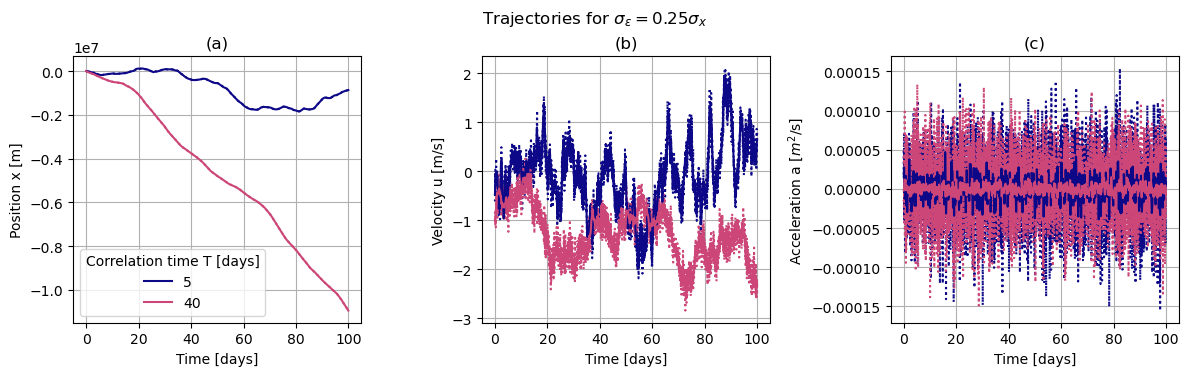

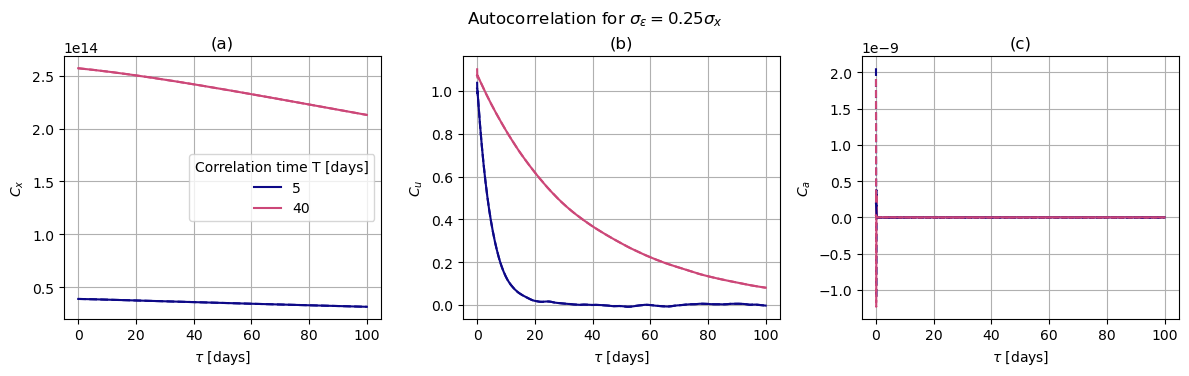

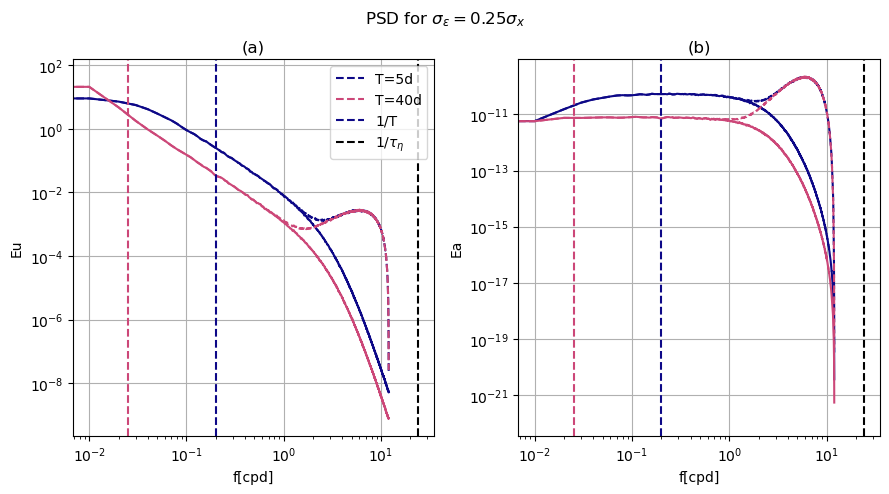

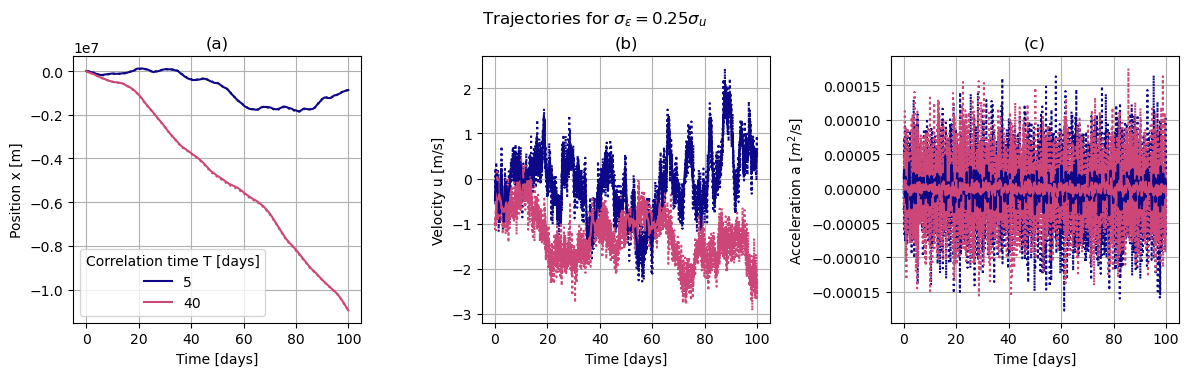

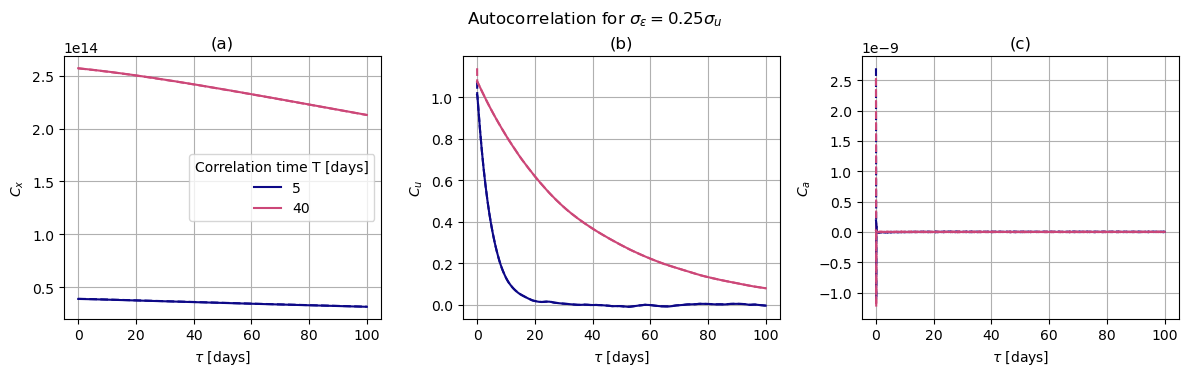

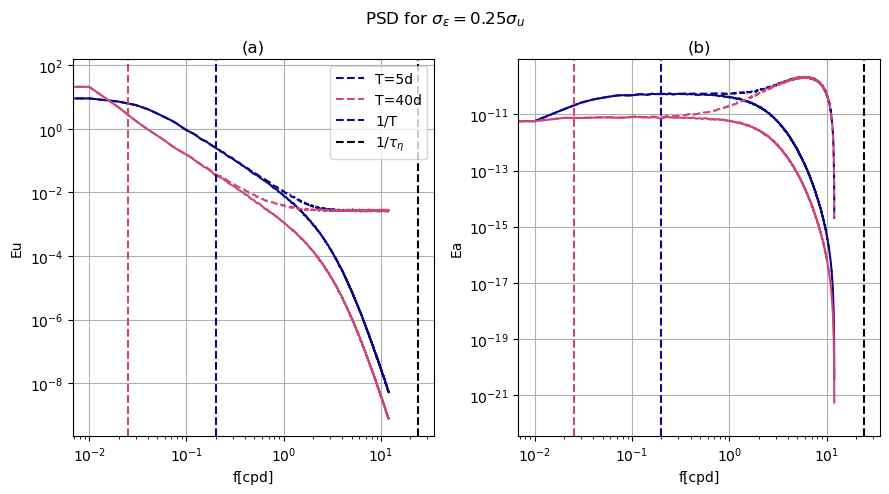

In [5]:
n1 = '_nx025'
n2 = '_nu025'
def plot_stat(ds, n1, ts=False, autocor=False, spectra=True, all_=False):
    suffixes_leg = ds.attrs['noise_suffixes_legend']
    if all_ : 
        ts =True,
        autocor=True
        spectra =True
    if ts : 
        fplt.plot_timeseries(ds.isel(draw=2), suffixes_ls = {n1:'dotted', '': 'solid', }, suffixes_leg = suffixes_leg[n1], title ='Trajectories for '+ suffixes_leg[n1]);
    if autocor : 
        fplt.plot_autocorrelations(ds.mean("draw"), tau_max=100, 
                      suffixes_ls = {n1:'dashed', '': 'solid', },
                              suffixes_leg = suffixes_leg[n1], 
                              title = 'Autocorrelation for '+ suffixes_leg[n1]);
    if spectra :
        fplt.plot_psd(ds, 
                   suffixes_ls = {n1:'dashed', '': 'solid', },
                   suffixes_leg = suffixes_leg,
                   title = 'PSD for '+ suffixes_leg[n1]);
plot_stat(ds.isel(T=[0,3]), n1, all_=True)
plot_stat(ds.isel(T=[0,3]), n2, all_=True)

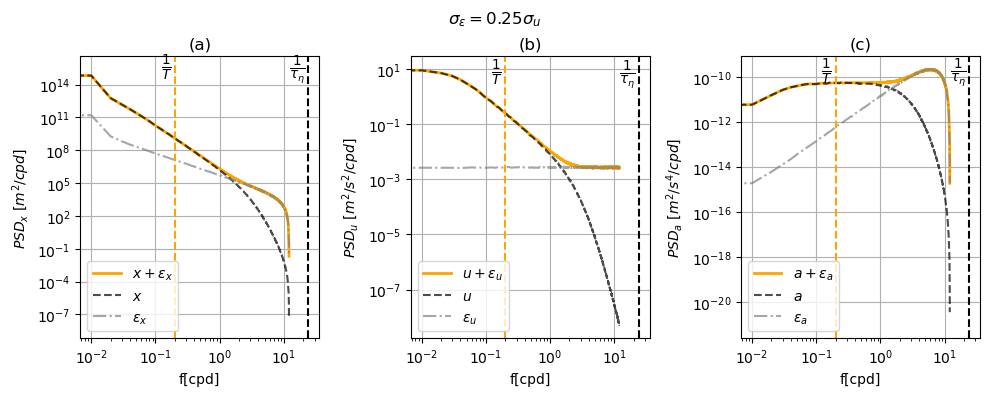

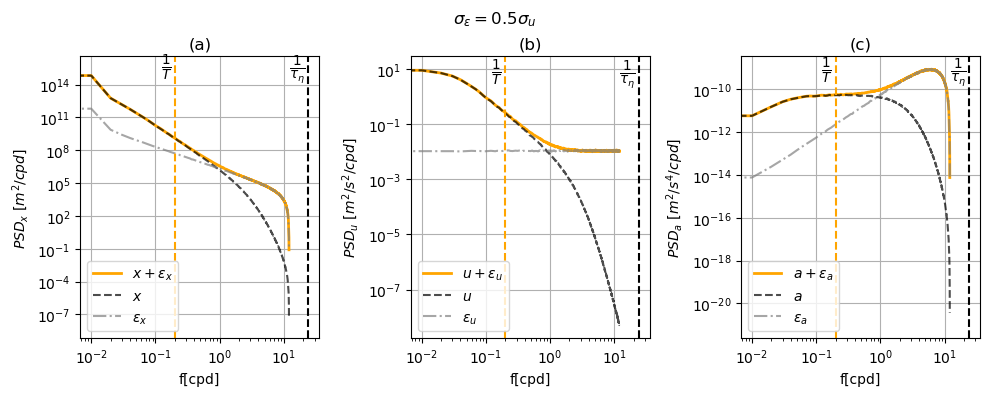

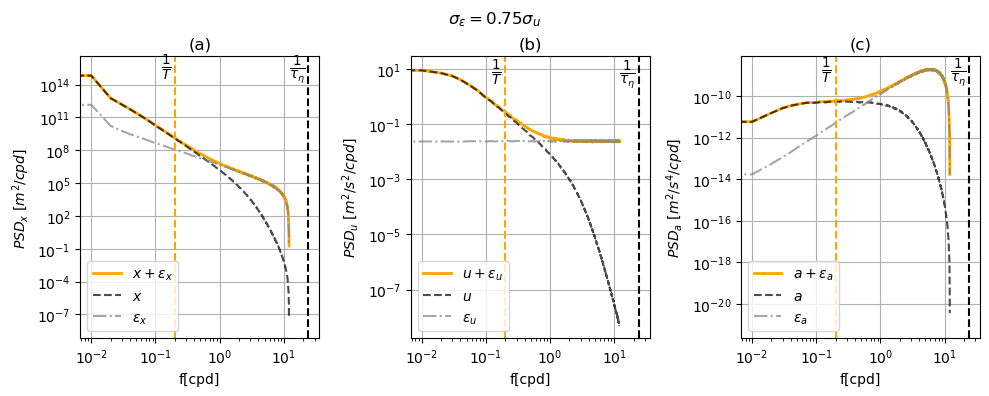

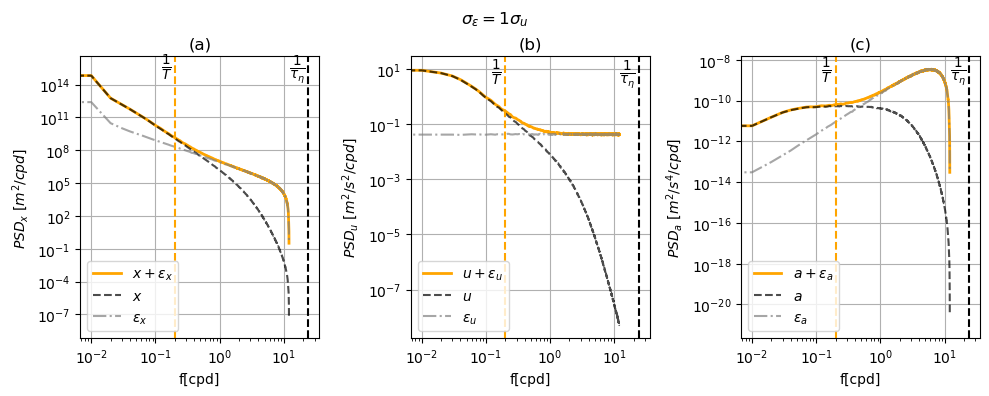

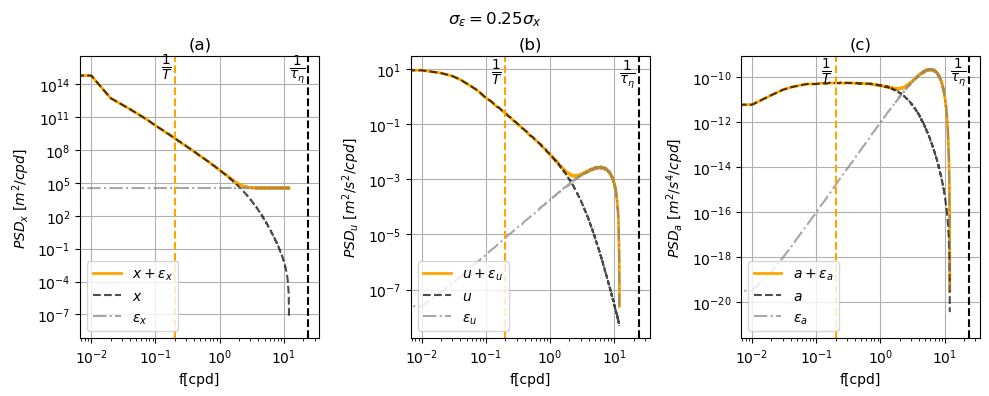

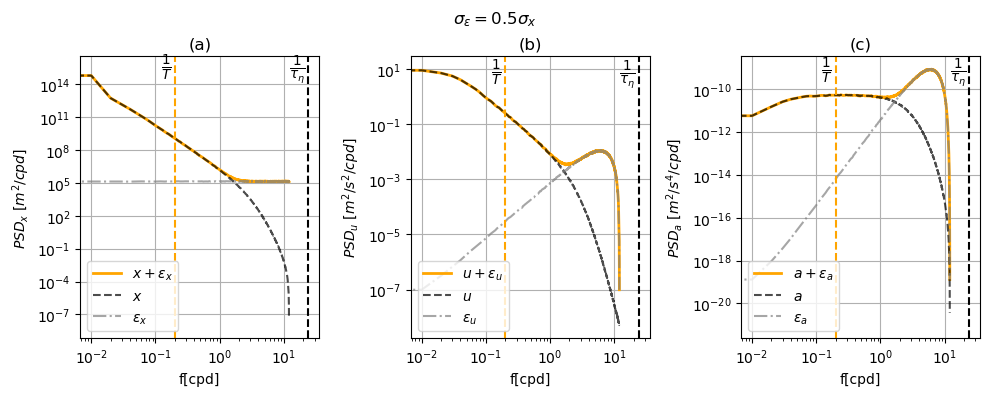

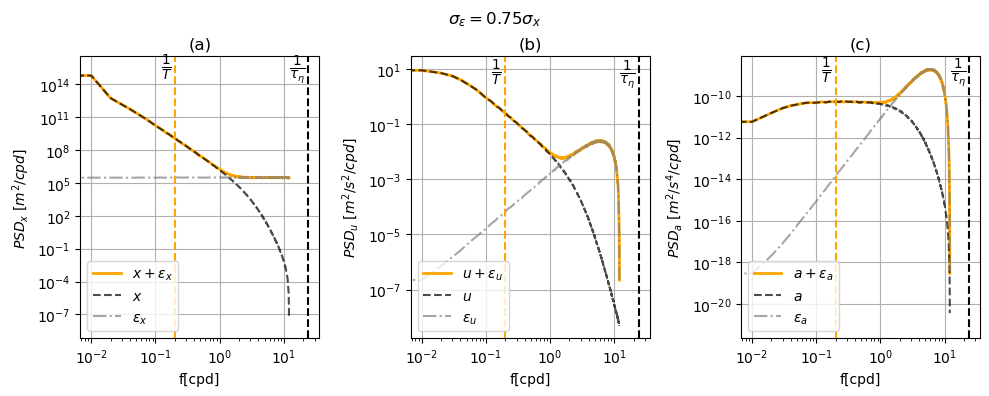

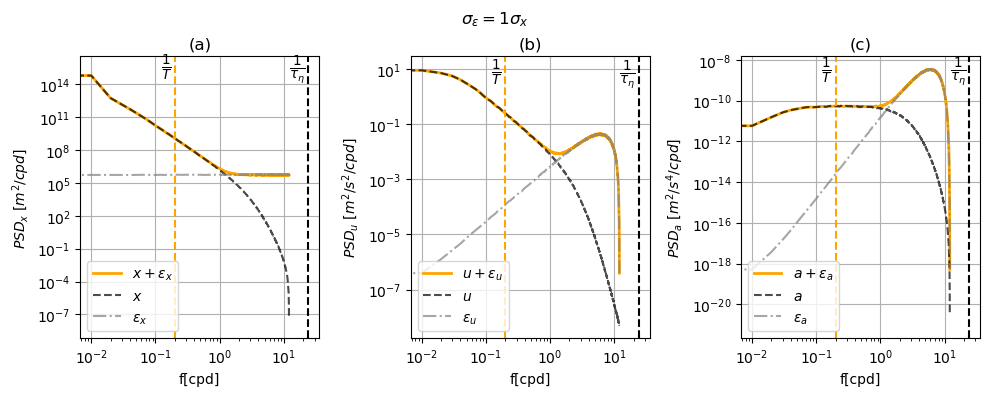

In [119]:
def plot_psd(ds, suf, c='orange') : 
    fig, axs = plt.subplots(1,3, figsize=(10,4))#, sharey=True)
    
    ax=axs[0]
    ds['Ex'+suf].mean("draw").plot(x="freq_time", ax=ax,lw=2, color=c, label=r"$x+\epsilon_x$")
    ds['Ex'].mean("draw").plot(x="freq_time", ax=ax, color='k', ls ='--', alpha=0.7, label=r"$x$")
    ds['Enx'+suf].mean("draw").plot(x="freq_time", ax=ax, color='grey', ls ='-.',alpha=0.7, label=r"$\epsilon_x$")
    #(ds['Enx'+suf]+ds['Ex']).mean("draw").plot(x="freq_time", ax=ax, color='b', ls ='-.',alpha=0.7, label=r"$\epsilon_x$")#verification sum PSD
    ax.set_title('(a)')
    ax.set_ylabel(r'$PSD_x$ $[m^2/cpd]$')
    
    ax=axs[1]
    ds['Eu'+suf].mean("draw").plot(x="freq_time", ax=ax, lw=2,color=c, label=r"$u+\epsilon_u$")
    ds['Eu'].mean("draw").plot(x="freq_time", ax=ax, color='k', ls ='--', alpha=0.7,label=r"$u$")
    ds['Enu'+suf].mean("draw").plot(x="freq_time", ax=ax, color='grey', ls ='-.',alpha=0.7, label=r"$\epsilon_u$")
    ax.set_title('(b)')
    ax.set_ylabel(r'$PSD_u$ $[m^2/s^2/cpd]$')
    
    ax=axs[2]
    ds['Ea'+suf].mean("draw").plot(x="freq_time", ax=ax,lw=2, color=c, label=r"$a+\epsilon_a$")
    ds['Ea'].mean("draw").plot(x="freq_time", ax=ax, color='k', ls ='--',alpha=0.7, label=r"$a$")
    ds['Ena'+suf].mean("draw").plot(x="freq_time", ax=ax, color='grey',alpha=0.7, ls ='-.', label=r"$\epsilon_a$")
    ax.set_title('(c)')
    ax.set_ylabel(r'$PSD_a$ $[m^2/s^4/cpd]$')
    

    
    # Vertical limitation
    for ax in axs :
        ax.axvline(x = 1/ds.T, color=c, ls='--')
        if 'tau_eta' in list(ds.coords) :
            ax.axvline(1/ds.tau_eta, color = 'k',ls ='--',)
            over_tau_eta = 1/ds.tau_eta
        elif 'tau_eta_days' in list(ds.attrs):
            ax.axvline(1/ds.attrs['tau_eta_days'], color = 'k',ls ='--',)
            over_tau_eta = 1/ds.attrs['tau_eta_days']
        lim=ax.get_ylim()
        ax.annotate(r'$\frac{1}{T}$',(1/ds.T-0.08, lim[1]-(lim[1]-lim[0])*0.5 ), fontsize=14)
        ax.annotate(r'$\frac{1}{\tau_{\eta}}$',(over_tau_eta-12, lim[1]-(lim[1]-lim[0])*0.5 ), fontsize=14)
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("f[cpd]")
        ax.legend(loc='lower left')
        ax.grid()
        
    fig.tight_layout(rect=[0,0,1,0.95])#left, bottom, right, top (default is 0,0,1,1)
    suffixes_leg = ds.attrs['noise_suffixes_legend']
    fig.suptitle(suffixes_leg[suf])
    
    return fig, axs

suffixes_leg = ds.attrs['noise_suffixes_legend']
for suf in suffixes_leg : 
    plot_psd(ds.isel(T=0), suf);


# Parseval on noise

In [121]:
suf='_nu05'
ds['Enu'+suf].integrate("freq_time").mean('draw').compute()#/ds['Enu'+suf].mean()).compute()

<xarray.DataArray 'Enu_nu05' (T: 4)>
array([0.26002651, 0.26030663, 0.26017112, 0.25989918])
Coordinates:
  * T        (T) int64 5 10 20 40

In [50]:
cluster.close()

NameError: name 'cluster' is not defined